In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import numpy as np
from lightgbm import LGBMRegressor
import lightgbm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px

In [2]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [106]:
btc_df = pd.read_parquet("data/BTCUSDT.pq")
btc_df = btc_df.sort_values(by = "time")
btc_df["return"] = (btc_df['close'] - btc_df['close'].shift(1))
btc_df = btc_df.drop(btc_df.index[0])

train_time = pd.to_datetime("08/01/24")

if not os.path.exists("market_neutral/"):
    os.mkdir("market_neutral/")

for filename in os.listdir("data/"):
    if filename.endswith(".pq") and filename != "BTCUSDT.pq":
        x_df = pd.read_parquet(os.path.join("data/", filename))
        x_df = x_df.sort_values(by = "time")
        x_df["return"] = (x_df["close"] - x_df["close"].shift(1))
        x_df = x_df.drop(x_df.index[0])

        if (x_df.shape[0] != btc_df.shape[0]) or (not all(btc_df.time == x_df.time)):
            # print(f"Times dont add up for file {filename}")
            continue
        
        X = btc_df["return"][btc_df["time"] < train_time].values.reshape(-1, 1)
        y = x_df["return"][x_df["time"] < train_time].values

        model = LinearRegression().fit(X, y)

        # print(f"Linear regression between BTC and {filename}:")
        # print(f"Slope (Beta): {model.coef_[0]}")
        # print(f"Intercept: {model.intercept_}")

        MN_x = x_df.copy()
        columns = ["open", "high", "low", "close", "return"]
        MN_x[columns] = x_df[columns] - model.coef_[0] * btc_df[columns]
        print(MN_x.head())
        break
        MN_x = MN_x.loc[:,["time", "return", "volume", "turnover"]] #makes above line a little reundant
        MN_x.reset_index(drop=True, inplace=True)
        
        MN_x.to_parquet(f"market_neutral/MN_{filename[:-3]}.pq")

                    time      open      high       low     close    volume  \
6550 2024-01-01 02:00:00 -0.086852 -0.081759 -0.086742 -0.081726  425655.4   
6549 2024-01-01 03:00:00 -0.081726 -0.080081 -0.084026 -0.083272  309383.0   
6548 2024-01-01 04:00:00 -0.083272 -0.081911 -0.083620 -0.083189  177727.0   
6547 2024-01-01 05:00:00 -0.083189 -0.082217 -0.083646 -0.083340  299739.4   
6546 2024-01-01 06:00:00 -0.083340 -0.083481 -0.086282 -0.085063  376649.9   

         turnover    return  
6550  81145.00025  0.005125  
6549  59503.78679 -0.001546  
6548  34101.52069  0.000084  
6547  57787.41344 -0.000151  
6546  71821.12503 -0.001723  


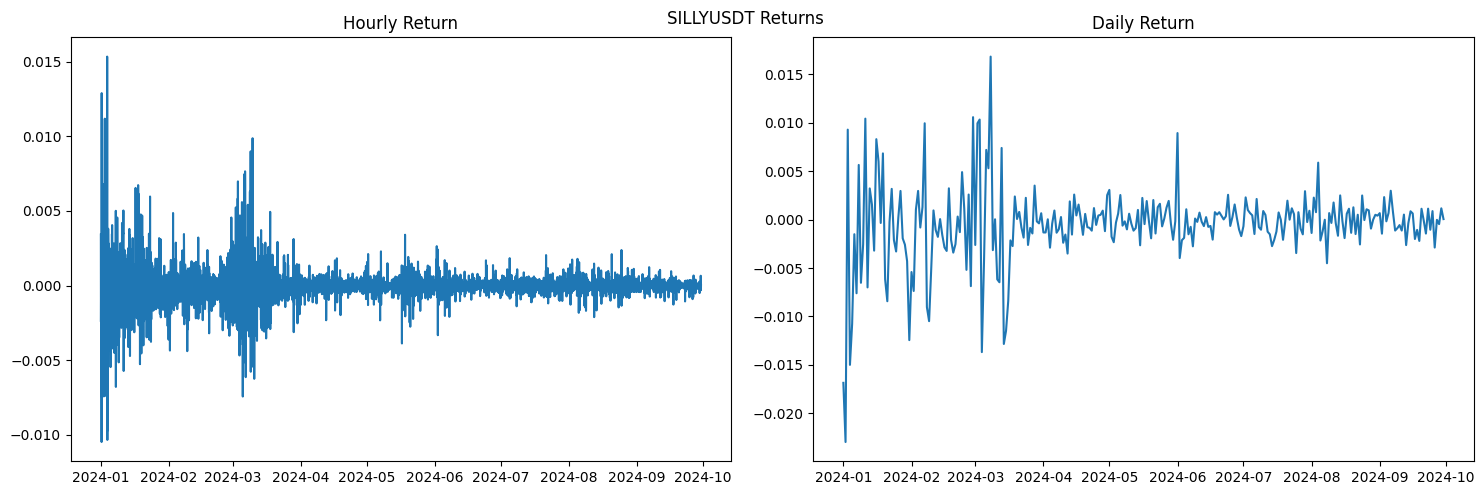

ADF Statistic: -13.870501
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
ADF Statistic: -7.769176
p-value: 0.000000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573
Stationary


In [4]:
mn_silly = pd.read_parquet("market_neutral/MN_SILLYUSDT.pq")
mn_silly.set_index("time", inplace=True)
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(mn_silly["return"])
axs[0].set_title("Hourly Return")


axs[1].plot(mn_silly.resample("D").sum().loc[:, "return"])
axs[1].set_title("Daily Return")
fig.tight_layout()
fig.suptitle("SILLYUSDT Returns")
plt.show()

check_stationarity(mn_silly["return"])
check_stationarity(mn_silly.resample("D").sum().loc[:, "return"])


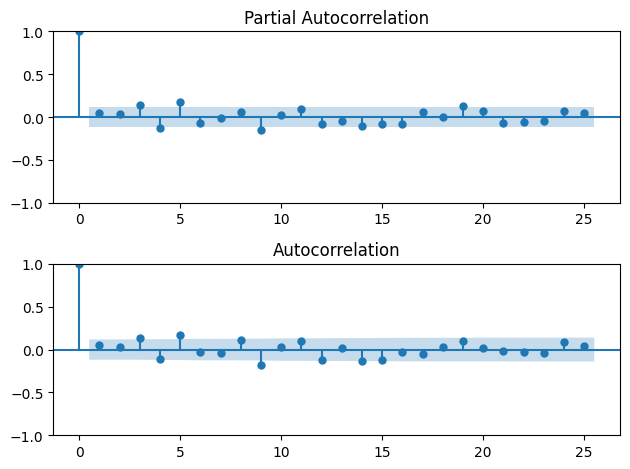

In [5]:
fig, ax = plt.subplots(nrows = 2, ncols = 1)
plot_pacf(mn_silly.resample("D").sum().loc[:, "return"], ax = ax[0])
plot_acf(mn_silly.resample("D").sum().loc[:, "return"], ax = ax[1])
plt.tight_layout()
plt.show()

LGBM Train MSE: 2.307514815401119e-06
LGBM Test MSE: 5.576866281029827e-06
Linear Train MSE: 1.3753038688968167e-05
Linear Test MSE: 4.027866645268391e-06
LGBM Correctness: 0.4166666666666667
Linear Correctness: 0.5


/var/folders/mf/j0jd6xtx3v15f0xj48w9cf8h0000gn/T/ipykernel_33969/2738436763.py:67: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



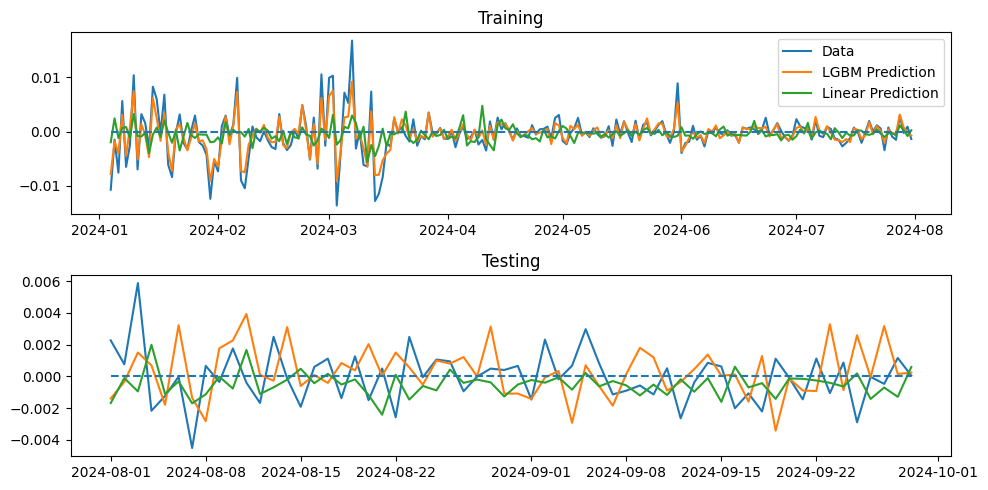

In [71]:
target_coin = pd.read_parquet("market_neutral/MN_SILLYUSDT.pq")
target_coin.set_index("time", inplace=True)
comp_coin = pd.read_parquet("market_neutral/MN_ALPHAUSDT.pq")
comp_coin.set_index("time", inplace= True)

comp = comp_coin.loc[:, ["return"]].resample("D").sum()

X = target_coin.loc[:, ["return"]].resample("D").sum()
X = X.rename(columns = {"return":"0d-lag"})
X["y"] = X["0d-lag"].shift(-1)

# Add features
X["1h-lag"] = target_coin.groupby(target_coin.index.date).tail(1).resample("D").sum()["return"]
X["2h-lag"] = target_coin.groupby(target_coin.index.date).tail(2).resample("D").sum()["return"]
X["1d-lag"] = X["0d-lag"].shift(1)
X["2d-lag"] = X["0d-lag"].shift(2)
X["3d-lag"] = X["0d-lag"].shift(3)

X["1h-lag-silly"] = comp_coin.groupby(comp_coin.index.date).tail(1).resample("D").sum()["return"]
X["2h-lag-silly"] = comp_coin.groupby(comp_coin.index.date).tail(2).resample("D").sum()["return"]
X["0d-lag-silly"] = comp["return"]
X["1d-lag-silly"] = comp["return"].shift(1)
X["2d-lag-silly"] = comp["return"].shift(2)
X["3d-lag-silly"] = comp["return"].shift(3)


X = X.dropna()
X_train = X[X.index < train_time]
y_train = X_train["y"]
X_train = X_train.drop(columns=["y"])
X_test = X[X.index >= train_time]
y_test = X_test["y"]
X_test = X_test.drop(columns=["y"])

params = {
    "verbose": -1
}
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train)
y_pred_train = lgbm_model.predict(X_train)
y_pred_test = lgbm_model.predict(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train_linear = linear_model.predict(X_train)
y_pred_test_linear = linear_model.predict(X_test)

print(f"LGBM Train MSE: {mean_squared_error(y_pred_train, y_train)}")
print(f"LGBM Test MSE: {mean_squared_error(y_pred_test, y_test)}")

print(f"Linear Train MSE: {mean_squared_error(y_pred_train_linear, y_train)}")
print(f"Linear Test MSE: {mean_squared_error(y_pred_test_linear, y_test)}")

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10,5))
ax[0].plot(y_train)
ax[0].plot(y_train.index, y_pred_train)
ax[0].plot(y_train.index, y_pred_train_linear)
ax[0].set_title("Training")
ax[0].hlines(0, y_train.index.min(), y_train.index.max(), linestyles="dashed")
ax[1].set_title("Testing")
ax[1].plot(y_test)
ax[1].plot(y_test.index, y_pred_test)
ax[1].plot(y_test.index, y_pred_test_linear)
ax[1].hlines(0, y_test.index.min(), y_test.index.max(), linestyles="dashed")
ax[0].legend(["Data", "LGBM Prediction", "Linear Prediction"])
fig.tight_layout()
fig.show()

print(f"LGBM Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test))/y_test.shape[0]}")
print(f"Linear Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test_linear))/y_test.shape[0]}")

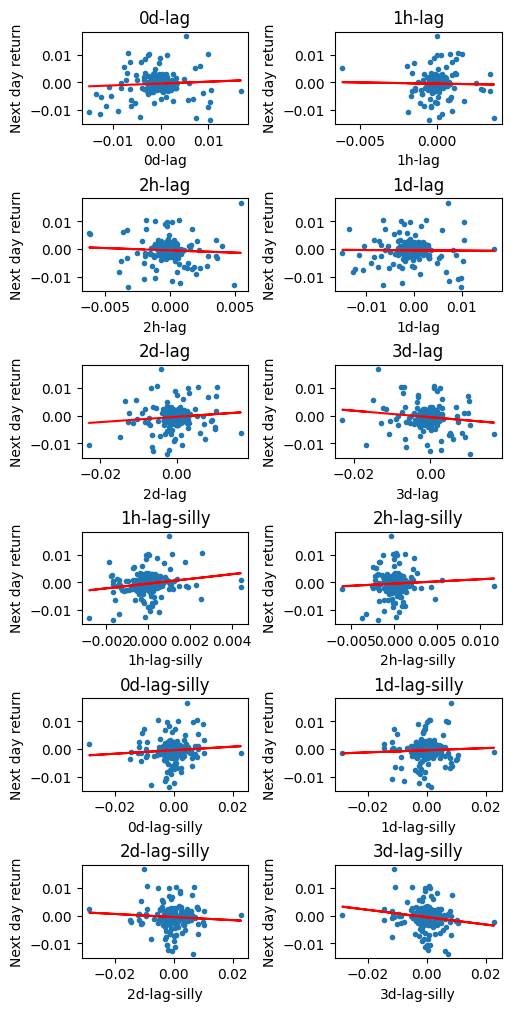

In [62]:
fig, axes = plt.subplots(nrows = 6, ncols=2, figsize=(5, 10), constrained_layout=True)

# Loop through each column and plot
for i, col in enumerate(X_train.columns):
    ax = axes[i // 2, i % 2]  # Determine subplot position

    # Scatter plot
    ax.plot(X_train[col], y_train, '.', label='Data points')

    # Fit the model
    model = LinearRegression()
    model.fit(X_train[col].values.reshape(-1, 1), y_train)

    # Plot the regression line
    ax.plot(X_train[col], model.predict(X_train[col].values.reshape(-1, 1)), color='red', label='Regression line')

    # Set title and labels
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Next day return')

    # Optional: Add legend

# Show the plots
plt.show()

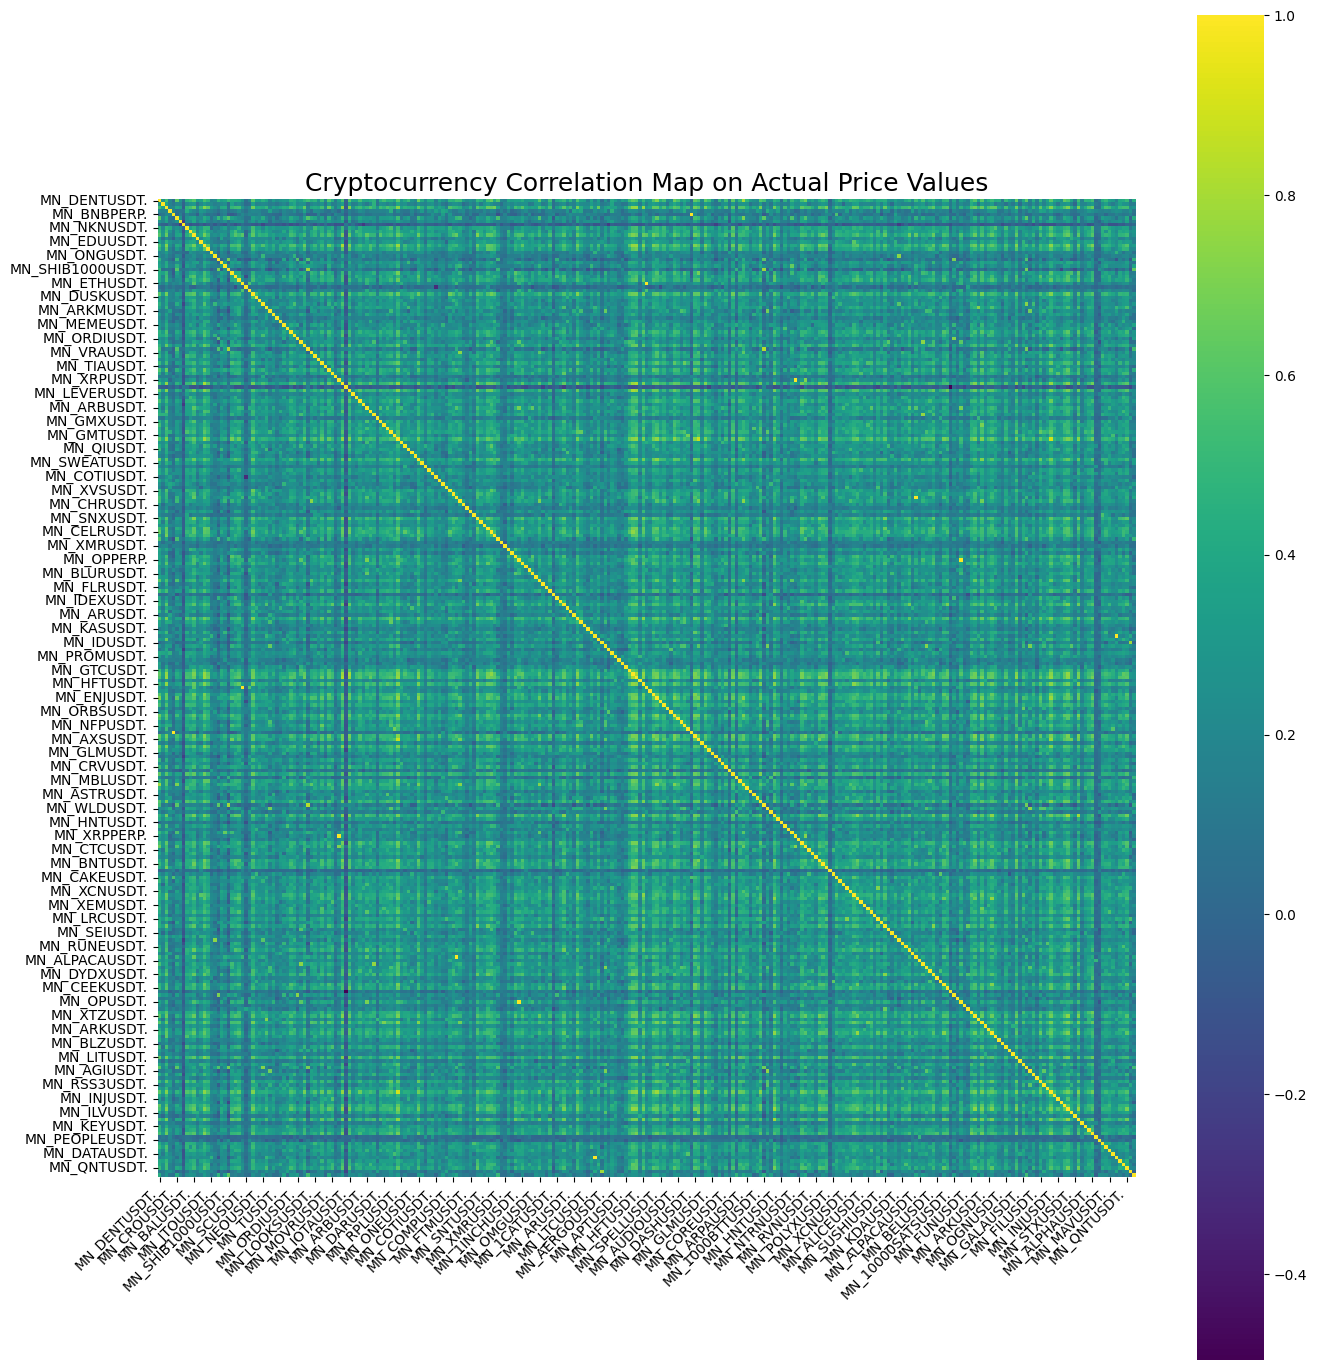

In [12]:
all_coins = {}

for filename in os.listdir("market_neutral/"):
    coin_df = pd.read_parquet(f"market_neutral/{filename}")
    coin_df.set_index("time", inplace=True)

    # Resample to daily returns and store in a dictionary
    coin_day_return = coin_df.resample("D").sum()["return"]
    coin_day_return.name = filename[:-2]
    all_coins[coin_day_return.name] = coin_day_return

# Combine all series into a DataFrame at once
all_coins_df = pd.DataFrame(all_coins)

corrmat = all_coins_df.corr()

fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corrmat, vmax=1., square=True, cmap="viridis")
plt.title("Cryptocurrency Correlation Map on Actual Price Values", fontsize=18)

# Adjust the size of tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')  # Adjust x-axis labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)  # Adjust y-axis labels

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [26]:
# Create a heatmap using Plotly
fig = px.imshow(
    corrmat,
    text_auto=True,
    color_continuous_scale='Viridis',
    aspect='equal'
)

# Update layout
fig.update_layout(
    title='Cryptocurrency Correlation Matrix',
    xaxis_title='Variables',
    yaxis_title='Variables',
    xaxis=dict(tickmode='linear'),
    yaxis=dict(tickmode='linear'),
    width=1000,
    height=1000
)

# Show the interactive heatmap
fig.show()

Most of the highly correlated stocks are ones that rallied in march and have gone down since. Most negative correlated stocks are ones that 
rallied in march and then those that have done well since march

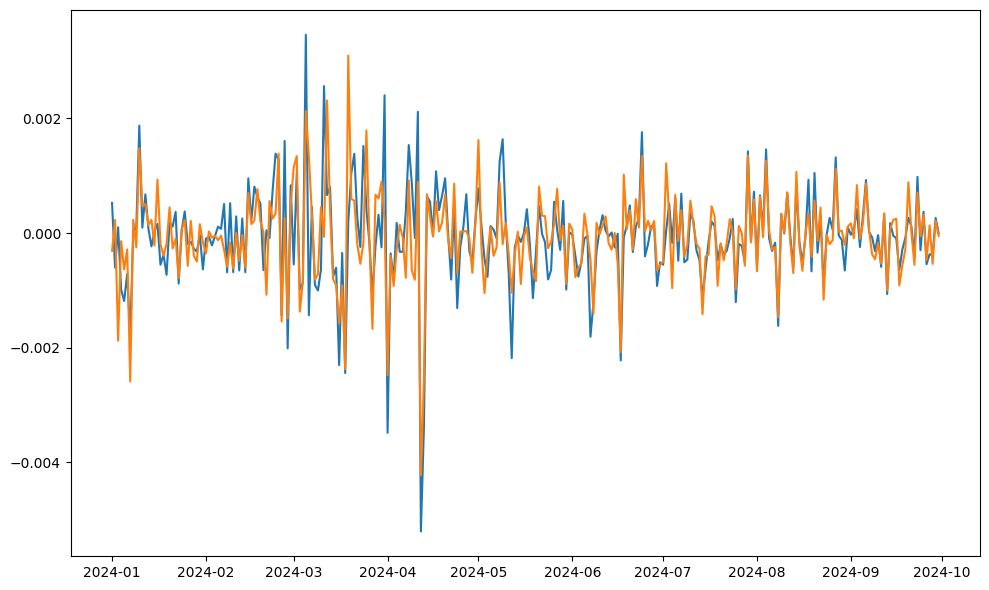

In [23]:
plt.figure(figsize=(10,6))
df = pd.read_parquet("market_neutral/MN_CELRUSDT.pq")
df.set_index("time", inplace=True)
df = df.resample("D").sum()
plt.plot(df["return"])
df = pd.read_parquet("market_neutral/MN_ZILUSDT.pq")
df.set_index("time", inplace=True)
df = df.resample("D").sum()
plt.plot(df["return"])
plt.tight_layout()
plt.show()

In [87]:
print(df["MN_DENTUSDT."].head())
print(shifted_df["MN_DENTUSDT."].head())

time
2024-01-01   -0.000024
2024-01-02   -0.000019
2024-01-03   -0.000084
2024-01-04   -0.000039
2024-01-05   -0.000067
Freq: D, Name: MN_DENTUSDT., dtype: float64
time
2024-01-01   -0.000019
2024-01-02   -0.000084
2024-01-03   -0.000039
2024-01-04   -0.000067
2024-01-05   -0.000008
Freq: D, Name: MN_DENTUSDT., dtype: float64


In [88]:
df = all_coins_df
corrmat = pd.DataFrame(index=df.columns, columns = df.columns)
shifted_df = df.shift(1)

for stock in df.columns:
    for other_stock in df.columns:
        corrmat.loc[stock, other_stock] = df[stock].corr(shifted_df[other_stock])

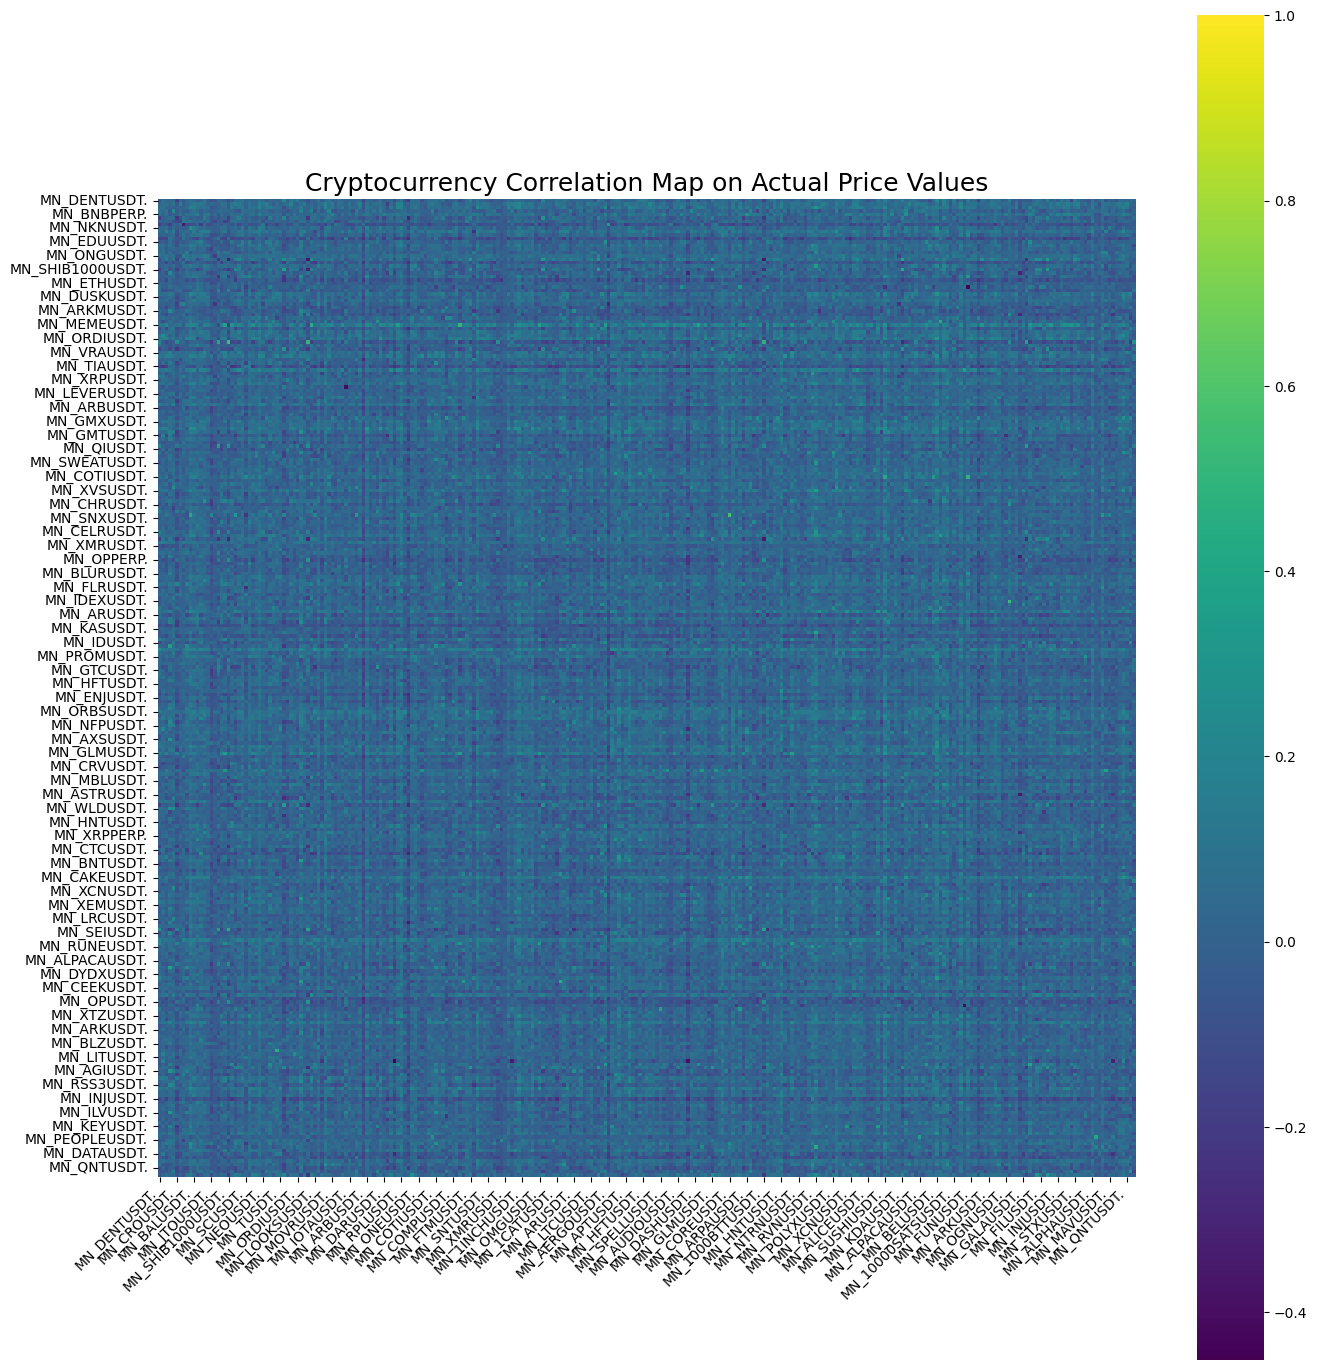

In [89]:
corrmat = corrmat.apply(pd.to_numeric, errors='coerce')

# Fill any NaN values with 0 or some other value (optional)
corrmat.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corrmat, vmax=1., square=True, cmap="viridis")
plt.title("Cryptocurrency Correlation Map on Actual Price Values", fontsize=18)

# Adjust the size of tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')  # Adjust x-axis labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)  # Adjust y-axis labels

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [90]:
# Create a heatmap using Plotly
fig = px.imshow(
    corrmat,
    text_auto=True,
    color_continuous_scale='Viridis',
    aspect='equal'
)

# Update layout
fig.update_layout(
    title='Cryptocurrency Correlation Matrix',
    xaxis_title='Day Lagged',
    yaxis_title='Today Return',
    xaxis=dict(tickmode='linear'),
    yaxis=dict(tickmode='linear'),
    width=1000,
    height=1000
)

# Show the interactive heatmap
fig.show()

LGBM Train MSE: 7.023742454782668e-08
LGBM Test MSE: 2.956164015824825e-08
Linear Train MSE: 1.3503269219170895e-07
Linear Test MSE: 1.4671138749727627e-08
LGBM Correctness: 0.5166666666666667
Linear Correctness: 0.45


/var/folders/mf/j0jd6xtx3v15f0xj48w9cf8h0000gn/T/ipykernel_33969/533983567.py:67: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



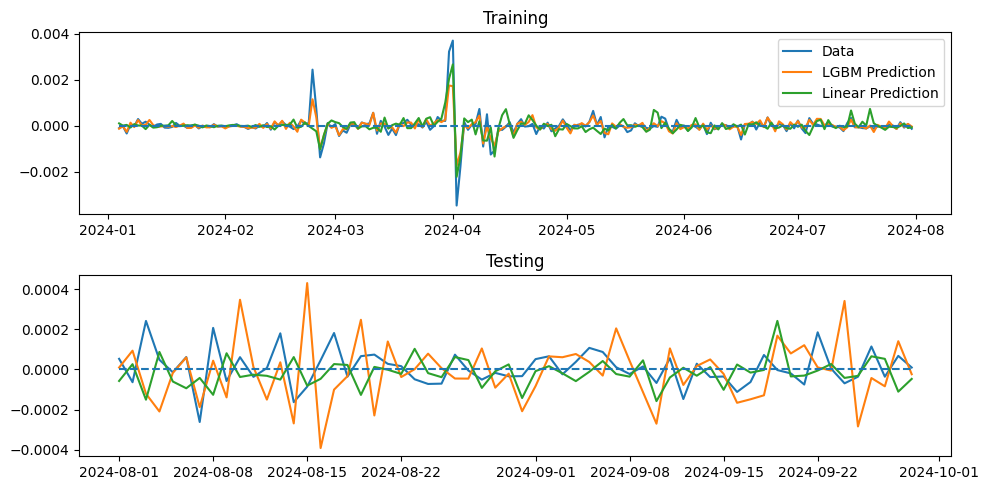

In [97]:
target_coin = pd.read_parquet("market_neutral/MN_XVGUSDT.pq")
target_coin.set_index("time", inplace=True)
comp_coin = pd.read_parquet("market_neutral/MN_COREUSDT.pq")
comp_coin.set_index("time", inplace= True)

comp = comp_coin.loc[:, ["return"]].resample("D").sum()

X = target_coin.loc[:, ["return"]].resample("D").sum()
X = X.rename(columns = {"return":"0d-lag"})
X["y"] = X["0d-lag"].shift(-1)

# Add features
X["1h-lag"] = target_coin.groupby(target_coin.index.date).tail(1).resample("D").sum()["return"]
X["2h-lag"] = target_coin.groupby(target_coin.index.date).tail(2).resample("D").sum()["return"]
X["1d-lag"] = X["0d-lag"].shift(1)
X["2d-lag"] = X["0d-lag"].shift(2)
X["3d-lag"] = X["0d-lag"].shift(3)

X["1h-lag-comp"] = comp_coin.groupby(comp_coin.index.date).tail(1).resample("D").sum()["return"]
X["2h-lag-comp"] = comp_coin.groupby(comp_coin.index.date).tail(2).resample("D").sum()["return"]
X["0d-lag-comp"] = comp["return"]
X["1d-lag-comp"] = comp["return"].shift(1)
X["2d-lag-comp"] = comp["return"].shift(2)
X["3d-lag-comp"] = comp["return"].shift(3)


X = X.dropna()
X_train = X[X.index < train_time]
y_train = X_train["y"]
X_train = X_train.drop(columns=["y"])
X_test = X[X.index >= train_time]
y_test = X_test["y"]
X_test = X_test.drop(columns=["y"])

params = {
    "verbose": -1
}
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train)
y_pred_train = lgbm_model.predict(X_train)
y_pred_test = lgbm_model.predict(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train_linear = linear_model.predict(X_train)
y_pred_test_linear = linear_model.predict(X_test)

print(f"LGBM Train MSE: {mean_squared_error(y_pred_train, y_train)}")
print(f"LGBM Test MSE: {mean_squared_error(y_pred_test, y_test)}")

print(f"Linear Train MSE: {mean_squared_error(y_pred_train_linear, y_train)}")
print(f"Linear Test MSE: {mean_squared_error(y_pred_test_linear, y_test)}")

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10,5))
ax[0].plot(y_train)
ax[0].plot(y_train.index, y_pred_train)
ax[0].plot(y_train.index, y_pred_train_linear)
ax[0].set_title("Training")
ax[0].hlines(0, y_train.index.min(), y_train.index.max(), linestyles="dashed")
ax[1].set_title("Testing")
ax[1].plot(y_test)
ax[1].plot(y_test.index, y_pred_test)
ax[1].plot(y_test.index, y_pred_test_linear)
ax[1].hlines(0, y_test.index.min(), y_test.index.max(), linestyles="dashed")
ax[0].legend(["Data", "LGBM Prediction", "Linear Prediction"])
fig.tight_layout()
fig.show()

print(f"LGBM Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test))/y_test.shape[0]}")
print(f"Linear Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test_linear))/y_test.shape[0]}")

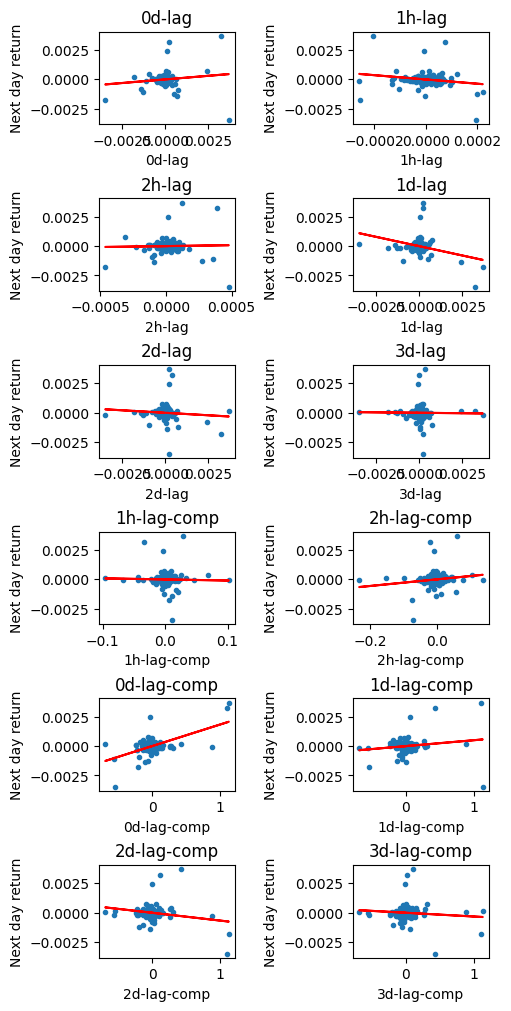

In [98]:
fig, axes = plt.subplots(nrows = 6, ncols=2, figsize=(5, 10), constrained_layout=True)

# Loop through each column and plot
for i, col in enumerate(X_train.columns):
    ax = axes[i // 2, i % 2]  # Determine subplot position

    # Scatter plot
    ax.plot(X_train[col], y_train, '.', label='Data points')

    # Fit the model
    model = LinearRegression()
    model.fit(X_train[col].values.reshape(-1, 1), y_train)

    # Plot the regression line
    ax.plot(X_train[col], model.predict(X_train[col].values.reshape(-1, 1)), color='red', label='Regression line')

    # Set title and labels
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Next day return')

    # Optional: Add legend

# Show the plots
plt.show()

LGBM Train MSE: 1.5985241659945733e-07
LGBM Test MSE: 1.662449050469646e-08
Linear Train MSE: 1.823010400444624e-07
Linear Test MSE: 1.3520000841589705e-08


/var/folders/mf/j0jd6xtx3v15f0xj48w9cf8h0000gn/T/ipykernel_33969/1906203205.py:67: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



LGBM Correctness: 0.5
Linear Correctness: 0.5


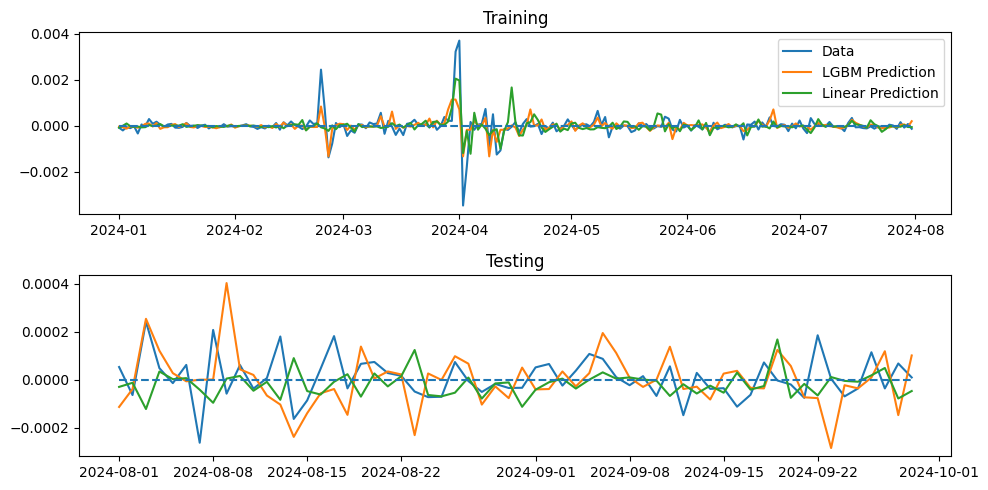

In [99]:
target_coin = pd.read_parquet("market_neutral/MN_XVGUSDT.pq")
target_coin.set_index("time", inplace=True)
comp_coin = pd.read_parquet("market_neutral/MN_COREUSDT.pq")
comp_coin.set_index("time", inplace= True)

comp = comp_coin.loc[:, ["return"]].resample("D").sum()

X = target_coin.loc[:, ["return"]].resample("D").sum()
X = X.rename(columns = {"return":"0d-lag"})
X["y"] = X["0d-lag"].shift(-1)

# Add features
# X["1h-lag"] = target_coin.groupby(target_coin.index.date).tail(1).resample("D").sum()["return"]
# X["2h-lag"] = target_coin.groupby(target_coin.index.date).tail(2).resample("D").sum()["return"]
# X["1d-lag"] = X["0d-lag"].shift(1)
# X["2d-lag"] = X["0d-lag"].shift(2)
# X["3d-lag"] = X["0d-lag"].shift(3)

# X["1h-lag-comp"] = comp_coin.groupby(comp_coin.index.date).tail(1).resample("D").sum()["return"]
# X["2h-lag-comp"] = comp_coin.groupby(comp_coin.index.date).tail(2).resample("D").sum()["return"]
X["0d-lag-comp"] = comp["return"]
# X["1d-lag-comp"] = comp["return"].shift(1)
# X["2d-lag-comp"] = comp["return"].shift(2)
# X["3d-lag-comp"] = comp["return"].shift(3)


X = X.dropna()
X_train = X[X.index < train_time]
y_train = X_train["y"]
X_train = X_train.drop(columns=["y"])
X_test = X[X.index >= train_time]
y_test = X_test["y"]
X_test = X_test.drop(columns=["y"])

params = {
    "verbose": -1
}
lgbm_model = LGBMRegressor(**params)
lgbm_model.fit(X_train, y_train)
y_pred_train = lgbm_model.predict(X_train)
y_pred_test = lgbm_model.predict(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train_linear = linear_model.predict(X_train)
y_pred_test_linear = linear_model.predict(X_test)

print(f"LGBM Train MSE: {mean_squared_error(y_pred_train, y_train)}")
print(f"LGBM Test MSE: {mean_squared_error(y_pred_test, y_test)}")

print(f"Linear Train MSE: {mean_squared_error(y_pred_train_linear, y_train)}")
print(f"Linear Test MSE: {mean_squared_error(y_pred_test_linear, y_test)}")

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(10,5))
ax[0].plot(y_train)
ax[0].plot(y_train.index, y_pred_train)
ax[0].plot(y_train.index, y_pred_train_linear)
ax[0].set_title("Training")
ax[0].hlines(0, y_train.index.min(), y_train.index.max(), linestyles="dashed")
ax[1].set_title("Testing")
ax[1].plot(y_test)
ax[1].plot(y_test.index, y_pred_test)
ax[1].plot(y_test.index, y_pred_test_linear)
ax[1].hlines(0, y_test.index.min(), y_test.index.max(), linestyles="dashed")
ax[0].legend(["Data", "LGBM Prediction", "Linear Prediction"])
fig.tight_layout()
fig.show()

print(f"LGBM Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test))/y_test.shape[0]}")
print(f"Linear Correctness: {np.sum(np.sign(y_test) == np.sign(y_pred_test_linear))/y_test.shape[0]}")

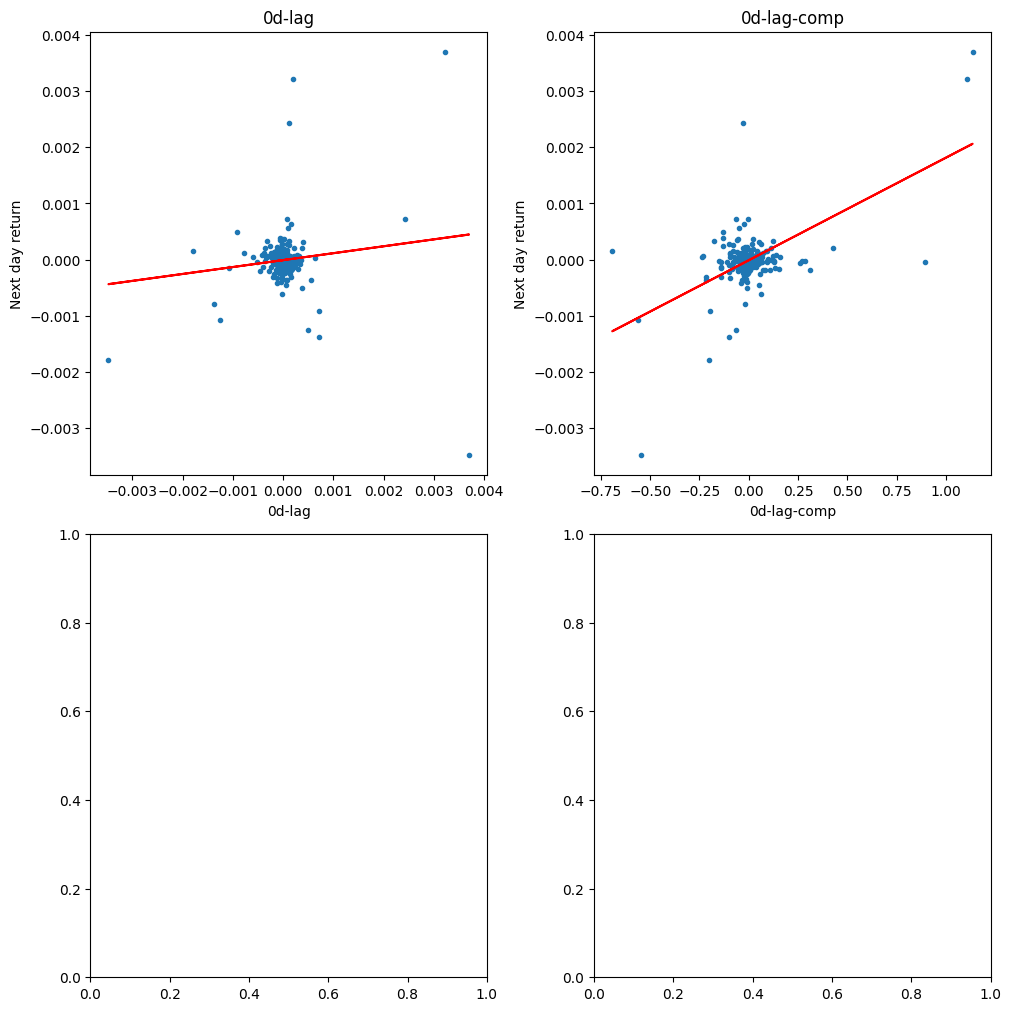

In [103]:
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(10, 10), constrained_layout=True)

# Loop through each column and plot
for i, col in enumerate(X_train.columns):
    ax = axes[i // 2, i % 2]  # Determine subplot position

    # Scatter plot
    ax.plot(X_train[col], y_train, '.', label='Data points')

    # Fit the model
    model = LinearRegression()
    model.fit(X_train[col].values.reshape(-1, 1), y_train)

    # Plot the regression line
    ax.plot(X_train[col], model.predict(X_train[col].values.reshape(-1, 1)), color='red', label='Regression line')

    # Set title and labels
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Next day return')

    # Optional: Add legend

# Show the plots
plt.show()